In [1]:
import pandas as pd
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
plots_folder = '../data/iplan_eda_plots/'
data_folder = '../data/'
file = 'iplan_sample.csv'
df=pd.read_csv(data_folder + file,parse_dates=
               ["repository_timestamp",
                "dms_timestamp",
                "start_date_time",
                "end_date_time",
                "realized_start_date_time",
                "realized_end_date_time",
                "decl_to_erp_system_date_time",
                "accept_by_employee_date_time",
                "viewable_for_emp_date_time",
                "deleted_date_time",
                "called_up_date_time",
               "start_date",
               "end_date"])

In [4]:
df = df[df['end_date_time'] < '2022-02-21 00:00:01']

print(df.shape)

print(f"{df.repository_timestamp.min()} - {df.repository_timestamp.max()}")
# what is the meaning of repository_timestamp? these dates suggest that shift data is modified long before shifts start, and after they finish

print(f"{df.start_date.min()} - {df.start_date.max()}")

print(f"{df.start_date.min().strftime('%A')} - {df.start_date.max().strftime('%A')}")

(269587, 23)
2021-11-03 11:30:42.201719 - 2022-02-22 15:26:29.545015
2022-02-14 00:00:00 - 2022-02-20 00:00:00
Monday - Sunday


In [5]:
df.shift_id = df.shift_id.astype('category')
df.pool_id = df.pool_id.astype('category')
df.employee_id = df.employee_id.astype('category')
df.pool_employee_id = df.pool_employee_id.astype('category')

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_value_df

,column_name,percent_missing
confirmed_date_time,confirmed_date_time,99.435804
decl_to_erp_system_date_time,decl_to_erp_system_date_time,80.407438
realized_end_date_time,realized_end_date_time,79.768312
realized_start_date_time,realized_start_date_time,79.716381
deleted_date_time,deleted_date_time,68.412423
accept_by_employee_date_time,accept_by_employee_date_time,59.542560
viewable_for_emp_date_time,viewable_for_emp_date_time,55.900693
called_up_date_time,called_up_date_time,38.854247
repository_timestamp,repository_timestamp,0.000000
pool_employee_id,pool_employee_id,0.000000


### What does a typical iPlan week look like?

- number of shifts
- number of employee
- number of pools
    - employees per pool
- average shifts per pool
- average employees per pool
- average employees per shift

In [7]:
print('Statistics for one week of sample data')
print(f'number of shifts: {df.shift_id.nunique()}')
print(f'number of employees: {df.employee_id.nunique()}')
print(f'number of pools: {df.pool_id.nunique()}')

Statistics for one week of sample data
number of shifts: 75273
number of employees: 44526
number of pools: 442


In [49]:
test=df.sample(10)
test

,repository_timestamp,op,dms_timestamp,id,shift_id,start_date_time,end_date_time,realized_start_date_time,realized_end_date_time,decl_to_erp_system_date_time,accept_by_employee_date_time,pool_id,deleted_date_time,employee_id,pool_employee_id,confirmed_date_time,viewable_for_emp_date_time,called_up_date_time,shift_day_of_week,start_date,end_date,start_time,end_time
96275,2022-02-09 16:29:59.412537,U,2022-02-09 15:27:59,151746683.0,156474968.0,2022-02-17 21:30:00,2022-02-18 06:15:00,NaT,NaT,NaT,NaT,19403.0,2022-02-09 16:27:59,1015702.0,1374724.0,NaN,2021-12-24 10:52:35,NaT,Thursday,2022-02-17,2022-02-18,21:30,06:15
213270,2022-02-14 15:26:39.565386,U,2022-02-14 14:27:32,153496155.0,158130599.0,2022-02-14 07:15:00,2022-02-14 15:00:00,2022-02-14 07:15:00,2022-02-14 15:00:00,2022-02-14 15:27:32,2022-02-08 08:22:33,22506.0,NaT,959919.0,1312005.0,NaN,NaT,2022-02-08 08:16:06,Monday,2022-02-14,2022-02-14,07:15,15:00
115125,2022-02-03 09:26:06.722751,D,2022-02-03 09:10:03,152591918.0,157312593.0,2022-02-15 07:30:00,2022-02-15 16:00:00,NaT,NaT,NaT,NaT,19423.0,NaT,818217.0,1129601.0,NaN,2022-01-17 02:57:20,NaT,Tuesday,2022-02-15,2022-02-15,07:30,16:00
39461,2022-01-06 13:26:57.842710,U,2022-01-06 12:37:19,151852150.0,155254936.0,2022-02-14 06:00:00,2022-02-14 10:00:00,NaT,NaT,NaT,NaT,22326.0,2022-01-06 13:36:57,1041663.0,1407354.0,NaN,2021-12-27 10:11:48,NaT,Monday,2022-02-14,2022-02-14,06:00,10:00
8590,2021-12-14 10:29:13.810051,D,2021-12-14 10:09:19,151229508.0,152973531.0,2022-02-17 07:30:00,2022-02-17 16:00:00,NaT,NaT,NaT,NaT,1766.0,NaT,1038850.0,1403615.0,NaN,2021-12-10 14:13:49,NaT,Thursday,2022-02-17,2022-02-17,07:30,16:00
260627,2022-02-21 10:27:00.414447,U,2022-02-21 09:30:22,153750794.0,156781954.0,2022-02-18 14:00:00,2022-02-18 22:00:00,2022-02-18 14:00:00,2022-02-18 21:45:00,2022-02-21 10:30:22,2022-02-14 10:45:55,7164.0,NaT,868145.0,1226932.0,NaN,NaT,2022-02-14 09:50:58,Friday,2022-02-18,2022-02-18,14:00,22:00
210698,2022-02-18 12:25:28.667278,U,2022-02-18 11:27:44,153134445.0,157803025.0,2022-02-16 08:30:00,2022-02-16 17:00:00,2022-02-16 08:30:00,2022-02-16 17:00:00,2022-02-18 12:27:44,2022-02-14 22:13:14,10822.0,NaT,937390.0,1283081.0,NaN,2022-01-31 02:35:52,2022-02-10 15:04:40,Wednesday,2022-02-16,2022-02-16,08:30,17:00
106254,2022-01-31 16:26:53.131223,U,2022-01-31 15:35:20,152949037.0,144785814.0,2022-02-19 14:30:00,2022-02-19 22:30:00,NaT,NaT,NaT,2022-01-25 18:11:47,11262.0,2022-01-31 15:02:51,1045118.0,1411732.0,NaN,NaT,2022-01-31 15:02:51,Saturday,2022-02-19,2022-02-19,14:30,22:30
117716,2022-02-10 13:26:05.303679,U,2022-02-10 12:24:35,153553596.0,157879627.0,2022-02-17 20:00:00,2022-02-18 04:30:00,NaT,NaT,NaT,NaT,42.0,2022-02-10 13:24:35,1045182.0,1411812.0,NaN,NaT,NaT,Thursday,2022-02-17,2022-02-18,20:00,04:30
56893,2022-02-07 13:26:24.433666,U,2022-02-07 12:47:35,152027515.0,156545236.0,2022-02-19 07:00:00,2022-02-19 15:30:00,NaT,NaT,NaT,NaT,6320.0,2022-02-07 13:47:35,894979.0,1229078.0,NaN,2022-01-03 02:02:55,NaT,Saturday,2022-02-19,2022-02-19,07:00,15:30


In [51]:
t2 = test[['pool_id','shift_id','employee_id','accept_by_employee_date_time','realized_start_date_time','confirmed_date_time']].groupby(['pool_id'], observed=True).agg({ 'shift_id':'nunique',
                                                                                                           'employee_id':'nunique',
                                                                                                          'accept_by_employee_date_time':'count',
                                                                                                          'realized_start_date_time':'count'})
t2

,shift_id,employee_id,accept_by_employee_date_time,realized_start_date_time
pool_id,,,,
19403.0,1,1,0,0
22506.0,1,1,1,1
19423.0,1,1,0,0
22326.0,1,1,0,0
1766.0,1,1,0,0
7164.0,1,1,1,1
10822.0,1,1,1,1
11262.0,1,1,1,0
42.0,1,1,0,0


In [53]:
t2.columns = ['num_shifts','num_employees','accepted_shifts','realised_shifts']
t2['pct_accepted'] = t2['accepted_shifts'] / t2['num_shifts'] * 100
t2['pct_realised'] = t2['realised_shifts'] / t2['num_shifts'] * 100
t2

,num_shifts,num_employees,accepted_shifts,realised_shifts,pct_accepted,pct_realised
pool_id,,,,,,
19403.0,1,1,0,0,0.0,0.0
22506.0,1,1,1,1,100.0,100.0
19423.0,1,1,0,0,0.0,0.0
22326.0,1,1,0,0,0.0,0.0
1766.0,1,1,0,0,0.0,0.0
7164.0,1,1,1,1,100.0,100.0
10822.0,1,1,1,1,100.0,100.0
11262.0,1,1,1,0,100.0,0.0
42.0,1,1,0,0,0.0,0.0


#### Pools

dist plot number of employees
dist plot number of shifts
average per day
average per day (mon-friday)

In [69]:
pooldf = df[['pool_id','shift_id','employee_id','accept_by_employee_date_time','realized_start_date_time','confirmed_date_time']].groupby(['pool_id']).agg({ 'shift_id':'nunique',
                                                                                                           'employee_id':'nunique',
                                                                                                           'accept_by_employee_date_time':'count',
                                                                                                           'realized_start_date_time':'count',
                                                                                                           'confirmed_date_time':'count'})
pooldf.columns = ['num_shifts','num_employees','accepted_shifts','realised_shifts','confirmed_shifts']
pooldf['pct_accepted'] = pooldf['accepted_shifts'] / pooldf['num_shifts'] * 100
pooldf['pct_realised'] = pooldf['realised_shifts'] / pooldf['num_shifts'] * 100
pooldf['pct_confirmed'] = pooldf['confirmed_shifts'] / pooldf['num_shifts'] * 100
pooldf['avg_shifts_pd'] = pooldf['num_shifts'] / 7
pooldf['shift_employee_ratio'] = (pooldf['num_employees'] / pooldf['num_shifts']) * 100
print(pooldf['avg_shifts_pd'].mean())
print(pooldf['shift_employee_ratio'].mean())

24.328700711053656
83.478621940437


In [10]:
print(len(pooldf[pooldf['num_shifts'] > 500]))
print(len(pooldf[pooldf['num_employees'] > 1000]))

29
2


In [11]:
# remove outliers
pooldf = pooldf[pooldf['num_shifts'] < 500]
pooldf = pooldf[pooldf['num_employees'] < 1000]

In [12]:
print(f"Shifts per pool: min: {pooldf['num_shifts'].min()}, max: {pooldf['num_shifts'].max()}, mean: {pooldf['num_shifts'].mean()}, median: {pooldf['num_shifts'].median()}")
print(f"Employees per pool: min: {pooldf['num_employees'].min()}, max: {pooldf['num_employees'].max()}, mean: {pooldf['num_employees'].mean()}, median: {pooldf['num_employees'].median()}")

Shifts per pool: min: 2, max: 498, mean: 102.95145631067962, median: 66.0
Employees per pool: min: 1, max: 727, mean: 71.54368932038835, median: 41.5


In [13]:
pooldf['avg_shifts_pd'].mean()

14.70735090152566

Text(0.5, 1.0, 'Distribution of Average Shifts per Day')

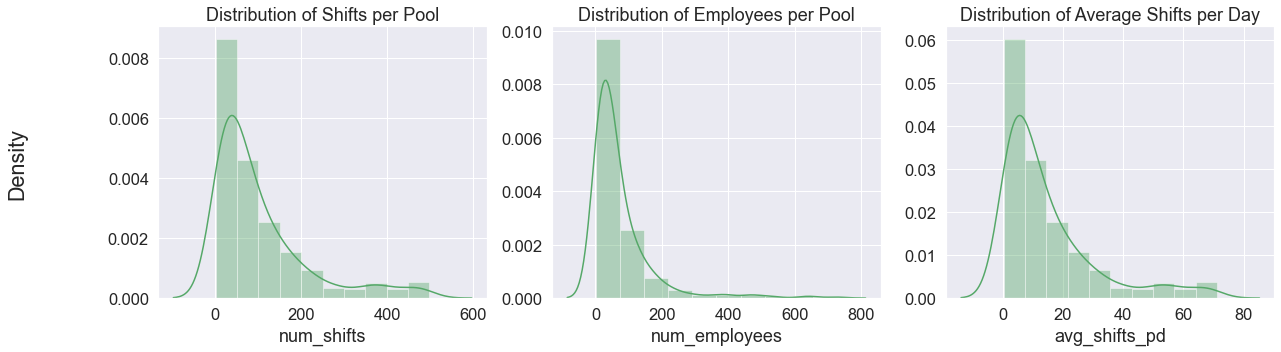

In [14]:
#define plotting region (2 rows, 2 columns)
sns.set(font_scale=1.5)
#fig, axes = plt.subplots(1, 3,figsize=(20,5))
#

fig = plt.figure(figsize=(20,5))
fig.supylabel('Density')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#create boxplot in each subplot
sns.distplot(pooldf['num_shifts'], color='g', bins=10, ax=ax1).set(ylabel=None)
ax1.set_title('Distribution of Shifts per Pool')
sns.distplot(pooldf['num_employees'], color='g', bins=10, ax=ax2).set(ylabel=None)
ax2.set_title('Distribution of Employees per Pool')
sns.distplot(pooldf['avg_shifts_pd'], color='g', bins=10, ax=ax3).set(ylabel=None)
ax3.set_title('Distribution of Average Shifts per Day')

#save = fig.get_figure()
#fig.savefig(plots_folder+"Pool Distributions.png") 


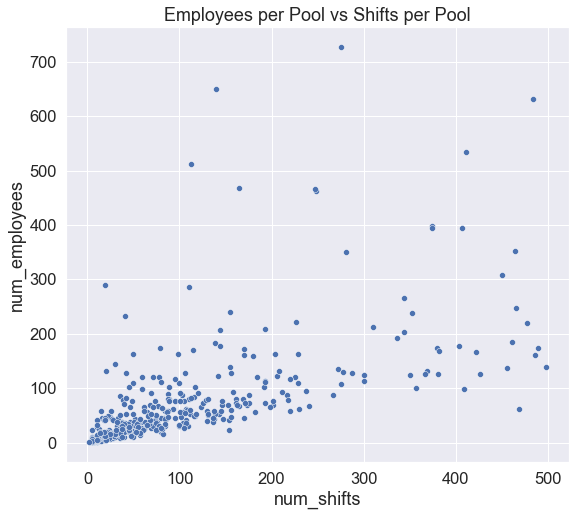

In [15]:
fig = plt.figure(figsize=(9, 8))
ax=sns.scatterplot(data=pooldf, x="num_shifts", y="num_employees").set_title('Employees per Pool vs Shifts per Pool')
#fig.savefig(plots_folder+"emplys_pr_pl_v_shfts_pr_pl.png") 

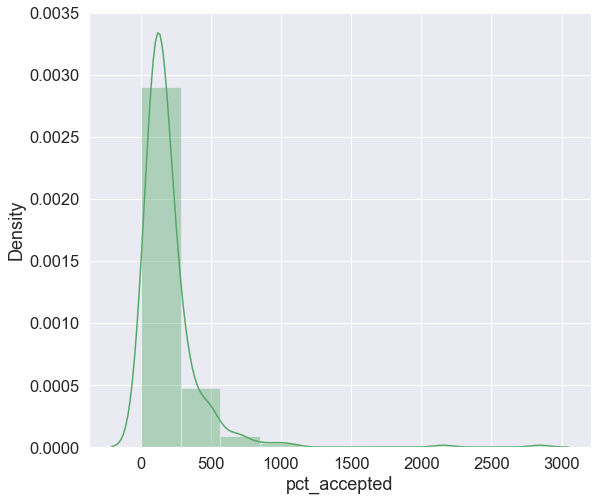

In [16]:
fig = plt.figure(figsize=(9, 8))
ax=sns.distplot(pooldf['pct_accepted'], color='g', bins=10)
#fig.savefig(plots_folder+"emplys_pr_pl_v_shfts_pr_pl.png") 


In [17]:
#### A closer look into small pools

In [54]:
len(pooldf[pooldf['avg_shifts_pd']<7].sort_values(['num_shifts','pct_accepted'],ascending=[True,False]))

169

In [70]:
simpool = pooldf[pooldf['avg_shifts_pd']<7].sort_values(['num_shifts','pct_accepted'],ascending=[True,False])
simpool.describe()

,num_shifts,num_employees,accepted_shifts,realised_shifts,confirmed_shifts,pct_accepted,pct_realised,pct_confirmed,avg_shifts_pd,shift_employee_ratio
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,23.840237,25.118343,54.011834,29.822485,0.804734,223.781625,122.219133,3.324327,3.405748,107.710813
std,13.267550,35.340489,69.432049,51.820241,3.126839,312.299926,232.855151,13.065417,1.895364,148.641613
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,20.000000
25%,12.000000,8.000000,13.000000,0.000000,0.000000,87.500000,0.000000,0.000000,1.714286,42.857143
50%,22.000000,15.000000,32.000000,3.000000,0.000000,148.387097,34.782609,0.000000,3.142857,63.829787
75%,35.000000,29.000000,69.000000,41.000000,0.000000,256.756757,170.000000,0.000000,5.000000,105.405405
max,48.000000,290.000000,540.000000,378.000000,25.000000,2842.105263,1890.000000,94.736842,6.857143,1526.315789


In [75]:
print(len(pooldf[(pooldf['avg_shifts_pd']<7)]))
print(len(pooldf[(pooldf['avg_shifts_pd']<7)&(pooldf['pct_accepted']>100)]))
print(len(pooldf[(pooldf['avg_shifts_pd']<7)&(pooldf['pct_realised']>100)]))
print(len(pooldf[(pooldf['avg_shifts_pd']<7)&(pooldf['pct_confirmed']>50)]))
print(len(pooldf[(pooldf['avg_shifts_pd']<7)&(pooldf['pct_confirmed']==0)]))

169
108
67
4
144


In [71]:
pooldf[(pooldf['avg_shifts_pd']>2)&(pooldf['avg_shifts_pd']<7)].sort_values(['num_shifts','pct_accepted'],ascending=[True,False]).head(20)

,num_shifts,num_employees,accepted_shifts,realised_shifts,confirmed_shifts,pct_accepted,pct_realised,pct_confirmed,avg_shifts_pd,shift_employee_ratio
pool_id,,,,,,,,,,
152.0,15,58,123,188,0,820.000000,1253.333333,0.000000,2.142857,386.666667
10242.0,15,7,29,33,0,193.333333,220.000000,0.000000,2.142857,46.666667
902.0,15,12,22,34,0,146.666667,226.666667,0.000000,2.142857,80.000000
13122.0,15,7,19,25,0,126.666667,166.666667,0.000000,2.142857,46.666667
21066.0,15,4,15,15,0,100.000000,100.000000,0.000000,2.142857,26.666667
749.0,16,45,58,44,1,362.500000,275.000000,6.250000,2.285714,281.250000
14763.0,16,5,2,0,0,12.500000,0.000000,0.000000,2.285714,31.250000
9582.0,17,6,16,19,0,94.117647,111.764706,0.000000,2.428571,35.294118
6358.0,17,8,2,0,0,11.764706,0.000000,0.000000,2.428571,47.058824


In [72]:
pooldf[pooldf['avg_shifts_pd']<7].sort_values(['num_shifts','pct_accepted'],ascending=[True,False]).head(10).to_csv(data_folder+"simple_pools_sample.csv",index=False)

In [57]:
df[df['pool_id']==17983.0]

,repository_timestamp,op,dms_timestamp,id,shift_id,start_date_time,end_date_time,realized_start_date_time,realized_end_date_time,decl_to_erp_system_date_time,accept_by_employee_date_time,pool_id,deleted_date_time,employee_id,pool_employee_id,confirmed_date_time,viewable_for_emp_date_time,called_up_date_time,shift_day_of_week,start_date,end_date,start_time,end_time
124895,2022-02-15 08:26:20.208440,U,2022-02-15 07:19:44,151451842.0,155281347.0,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-15 08:19:44,2022-01-28 16:11:21,17983.0,NaT,902088.0,1238192.0,NaN,NaT,2022-01-28 15:54:10,Monday,2022-02-14,2022-02-14,08:00,16:30
128912,2022-02-15 08:26:20.208440,U,2022-02-15 07:19:44,153031269.0,155281347.0,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-15 08:19:44,2022-01-31 10:02:18,17983.0,NaT,832386.0,1148105.0,NaN,NaT,2022-01-28 15:54:20,Monday,2022-02-14,2022-02-14,08:00,16:30
129034,2022-02-15 08:26:20.208440,U,2022-02-15 07:19:44,153059777.0,155281347.0,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-14 08:00:00,2022-02-14 16:30:00,2022-02-15 08:19:44,2022-01-28 16:05:44,17983.0,NaT,736447.0,1023422.0,NaN,NaT,2022-01-28 15:52:21,Monday,2022-02-14,2022-02-14,08:00,16:30
148380,2022-02-17 07:26:17.484645,U,2022-02-17 07:10:25,153052657.0,155281348.0,2022-02-15 08:00:00,2022-02-15 16:30:00,2022-02-15 08:00:00,2022-02-15 16:30:00,2022-02-17 08:10:25,2022-01-29 15:47:37,17983.0,NaT,736462.0,1023437.0,NaN,NaT,2022-01-28 15:51:24,Tuesday,2022-02-15,2022-02-15,08:00,16:30
148381,2022-02-17 07:26:17.484645,U,2022-02-17 07:10:27,153088193.0,155281349.0,2022-02-16 08:00:00,2022-02-16 16:30:00,2022-02-16 08:00:00,2022-02-16 16:15:00,2022-02-17 08:10:27,2022-01-28 16:13:50,17983.0,NaT,731646.0,1024733.0,NaN,NaT,2022-01-28 15:57:11,Wednesday,2022-02-16,2022-02-16,08:00,16:30
150946,2022-02-11 09:26:36.814514,U,2022-02-11 09:03:52,151452065.0,155281347.0,2022-02-14 08:00:00,2022-02-14 16:30:00,NaT,NaT,NaT,2022-01-28 16:36:46,17983.0,NaT,736461.0,1023436.0,NaN,NaT,2022-01-28 15:51:02,Monday,2022-02-14,2022-02-14,08:00,16:30
167379,2022-02-18 13:28:26.673951,U,2022-02-18 13:02:43,153088215.0,155281351.0,2022-02-18 08:00:00,2022-02-18 16:30:00,2022-02-18 08:00:00,2022-02-18 14:45:00,2022-02-18 14:02:43,2022-01-28 16:13:50,17983.0,NaT,731646.0,1024733.0,NaN,NaT,2022-01-28 15:57:16,Friday,2022-02-18,2022-02-18,08:00,16:30
167396,2022-02-18 13:28:26.673951,U,2022-02-18 13:02:41,151451875.0,155281350.0,2022-02-17 08:00:00,2022-02-17 16:30:00,2022-02-17 08:00:00,2022-02-17 16:30:00,2022-02-18 14:02:41,2022-01-28 16:11:22,17983.0,NaT,902088.0,1238192.0,NaN,NaT,2022-01-28 15:54:16,Thursday,2022-02-17,2022-02-17,08:00,16:30
167410,2022-02-18 13:28:26.673951,U,2022-02-18 13:02:43,153273692.0,155281351.0,2022-02-18 08:00:00,2022-02-18 16:30:00,2022-02-18 08:00:00,2022-02-18 12:30:00,2022-02-18 14:02:42,2022-02-04 14:10:57,17983.0,NaT,736442.0,1023416.0,NaN,NaT,2022-02-02 13:57:00,Friday,2022-02-18,2022-02-18,08:00,16:30
167434,2022-02-18 13:28:26.673951,U,2022-02-18 13:02:41,153052379.0,155281350.0,2022-02-17 08:00:00,2022-02-17 16:30:00,2022-02-17 08:00:00,2022-02-17 16:30:00,2022-02-18 14:02:41,NaT,17983.0,NaT,768244.0,1064819.0,NaN,NaT,2022-01-28 15:50:50,Thursday,2022-02-17,2022-02-17,08:00,16:30


In [41]:
twentynine = df[df['pool_id'] == 29.0]
twentynine[["shift_id","shift_day_of_week"]].groupby('shift_day_of_week')['shift_id'].nunique()

In [45]:
print(twentynine.employee_id.nunique())
print(twentynine.shift_id.nunique())

20
41


In [44]:
one = df[df['pool_id'] == 1.0]
one[["shift_id","shift_day_of_week"]].groupby('shift_day_of_week')['shift_id'].nunique()

shift_day_of_week
Friday       4
Monday       2
Thursday     3
Tuesday      2
Wednesday    2
Name: shift_id, dtype: int64

In [73]:
print(one.employee_id.nunique())
print(one.shift_id.nunique())

8
13


In [74]:
one.head(2)

,repository_timestamp,op,dms_timestamp,id,shift_id,start_date_time,end_date_time,realized_start_date_time,realized_end_date_time,decl_to_erp_system_date_time,accept_by_employee_date_time,pool_id,deleted_date_time,employee_id,pool_employee_id,confirmed_date_time,viewable_for_emp_date_time,called_up_date_time,shift_day_of_week,start_date,end_date,start_time,end_time
35184,2022-01-31 00:26:21.660763,I,2022-01-31 00:03:59,153093497.0,157705109.0,2022-02-16 13:00:00,2022-02-16 17:00:00,NaT,NaT,NaT,NaT,1.0,NaT,508579.0,723013.0,NaN,2022-01-31 01:03:59,NaT,Wednesday,2022-02-16,2022-02-16,13:00,17:00
35186,2022-01-31 00:26:21.660763,I,2022-01-31 00:03:59,153093494.0,157705111.0,2022-02-18 13:00:00,2022-02-18 17:00:00,NaT,NaT,NaT,NaT,1.0,NaT,248509.0,329900.0,NaN,2022-01-31 01:03:59,NaT,Friday,2022-02-18,2022-02-18,13:00,17:00


In [98]:
onedf = one[['repository_timestamp','shift_id','start_date_time','end_date_time','start_time','end_time','start_date','end_date', \
            'employee_id']].sort_values('start_date_time')
onedf.drop_duplicates(subset=['shift_id'])

,repository_timestamp,shift_id,start_date_time,end_date_time,start_time,end_time,start_date,end_date,employee_id
40349,2022-01-31 00:26:21.660763,157705086.0,2022-02-14 09:00:00,2022-02-14 12:00:00,09:00,12:00,2022-02-14,2022-02-14,246985.0
46514,2022-01-31 00:26:21.660763,157705107.0,2022-02-14 13:00:00,2022-02-14 17:00:00,13:00,17:00,2022-02-14,2022-02-14,307003.0
42231,2022-01-31 00:26:21.660763,157705087.0,2022-02-15 09:00:00,2022-02-15 12:00:00,09:00,12:00,2022-02-15,2022-02-15,248509.0
66664,2022-01-31 00:26:21.660763,157705108.0,2022-02-15 13:00:00,2022-02-15 17:00:00,13:00,17:00,2022-02-15,2022-02-15,659770.0
40370,2022-01-31 00:26:21.660763,157705088.0,2022-02-16 09:00:00,2022-02-16 12:00:00,09:00,12:00,2022-02-16,2022-02-16,307003.0
102448,2022-01-31 00:26:21.660763,157705109.0,2022-02-16 13:00:00,2022-02-16 17:00:00,13:00,17:00,2022-02-16,2022-02-16,246985.0
42228,2022-01-31 00:26:21.660763,157705089.0,2022-02-17 09:00:00,2022-02-17 12:00:00,09:00,12:00,2022-02-17,2022-02-17,307003.0
203740,2022-02-17 17:25:57.804972,157310019.0,2022-02-17 09:00:00,2022-02-17 23:00:00,09:00,23:00,2022-02-17,2022-02-17,1030039.0
42229,2022-01-31 00:26:21.660763,157705110.0,2022-02-17 13:00:00,2022-02-17 17:00:00,13:00,17:00,2022-02-17,2022-02-17,456212.0
66661,2022-01-31 00:26:21.660763,157705118.0,2022-02-18 09:00:00,2022-02-18 17:00:00,09:00,17:00,2022-02-18,2022-02-18,312669.0


### Shifts

In [ ]:
dist plot number of employees
per day?
common start times

### Employees

In [91]:
#outliers
outliers=[]
outliers.extend(pooldf.index[pooldf['num_shifts'] > 500].tolist())
outliers.extend(pooldf.index[pooldf['num_employees'] > 1000].tolist())

In [ ]:
dist plot number of shifts
are any in more than one pool?

accept_by_employee_date_time

In [1]:
len(outliers)

NameError: name 'outliers' is not defined

In [92]:
df[~df['pool_id'].isin(outliers)].shape

(161989, 23)

In [94]:
empdf = df[~df['pool_id'].isin(outliers)]
empdf = empdf[['pool_id','shift_id','employee_id','accept_by_employee_date_time']].groupby(['employee_id']).agg({'shift_id' : 'nunique', 
                                                                                                              'pool_id' : 'nunique',
                                                                                                             'accept_by_employee_date_time' : 'count'})

empdf.columns = ['num_shifts','num_pools','num_accepted']

In [95]:
empdf.head()

,num_shifts,num_pools,num_accepted
employee_id,,,
1665.0,4,1,4
1977.0,1,1,1
2553.0,0,0,0
2587.0,6,1,4
2929.0,5,1,5


In [96]:
print(f"Shifts per employee: min: {empdf['num_shifts'].min()}, max: {empdf['num_shifts'].max()}, mean: {empdf['num_shifts'].mean()}, median: {empdf['num_shifts'].median()}")
print(f"Accepted shifts per employee: min: {empdf['num_accepted'].min()}, max: {empdf['num_accepted'].max()}, mean: {empdf['num_accepted'].mean()}, median: {empdf['num_accepted'].median()}")
print(f"Accepted shifts per employee: min: {empdf['num_pools'].min()}, max: {empdf['num_pools'].max()}, mean: {empdf['num_pools'].mean()}, median: {empdf['num_pools'].median()}")


Shifts per employee: min: 0, max: 95, mean: 3.4761038494362846, median: 4.0
Accepted shifts per employee: min: 0, max: 15, mean: 1.7211966042312357, median: 0.0
Accepted shifts per employee: min: 0, max: 3, mean: 0.6619952387369178, median: 1.0


In [80]:
print(f"Shifts per employee: min: {empdf['num_shifts'].min()}, max: {empdf['num_shifts'].max()}, mean: {empdf['num_shifts'].mean()}, median: {empdf['num_shifts'].median()}")
print(f"Accepted shifts per employee: min: {empdf['num_accepted'].min()}, max: {empdf['num_accepted'].max()}, mean: {empdf['num_accepted'].mean()}, median: {empdf['num_accepted'].median()}")
print(f"Accepted shifts per employee: min: {empdf['num_pools'].min()}, max: {empdf['num_pools'].max()}, mean: {empdf['num_pools'].mean()}, median: {empdf['num_pools'].median()}")


Shifts per employee: min: 1, max: 95, mean: 5.807977361541571, median: 5.0
Accepted shifts per employee: min: 0, max: 22, mean: 2.4495351030858377, median: 2.0
Accepted shifts per employee: min: 1, max: 4, mean: 1.0104882540538112, median: 1.0


In [97]:
print(f"Number of employees in more than 1 pool: {len(empdf[empdf['num_pools']>1])} ({(len(empdf[empdf['num_pools']>1])/len(empdf))*100}%)")

Number of employees in more than 1 pool: 247 (0.5547320666576832%)


In [ ]:
empdf[empdf['num_accepted'] > 10].sort_values(['num_accepted'],ascending=False)

In [ ]:
#df[df['pool_id']==225.0]

In [ ]:
df[df['employee_id']==1047368.0].sort_values('start_date_time')

In [ ]:
df.head()